In [1]:
import gc
import os
import numpy as np 
import pandas as pd 
import utils.paths as plh
import utils.read_utils as hlpread
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from src.models.feature_eng.TE_KFold import KFoldTargetEncoder
from src.models.feature_eng.FreqEncoding import FrequencyEncoding
from src.models.feature_eng.Combine_feature import CombineFeatures
from src.models.feature_eng.KFoldFreqEncoding import KFoldFrequencyEncoding
from src.models.feature_eng.CountVectorizerEncoding import CountVectorizerEncoding
from src.models.feature_eng.TFIDFVectorizerEncoding import TFIDFVectorizerEncoding

In [2]:
PROJECT_ROOT = plh.get_project_root()

train_data = os.path.join(PROJECT_ROOT, 
                          hlpread.read_yaml_key('data_source.data_folders'),
                          hlpread.read_yaml_key('data_source.prepared.folder'),
                          hlpread.read_yaml_key('data_source.prepared.clean_train'),
                        )
train = hlpread.read_from_parquet(train_data)

print(train.shape)

print(train.columns)
#col_use = [x for x in train.columns if not x in ['ROLE_TITLE', 'MGR_ID']]
#train = train[col_use]
#targetcol = 'ACTION'

#te_col = list(train.columns)
#te_col.remove(targetcol)

(30391, 10)
Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')


In [6]:
#Order of the pipeline matter as this impact the output
feature_engg = Pipeline( steps = [
                                ('combine_feature', CombineFeatures()),  

                                #('label_encoder', LabelEncoder()),                              

                                ('tfidf_vectorizer_encoding', TFIDFVectorizerEncoding()),

                                #('count_vectorizer_encoding', CountVectorizerEncoding()),

                                ('frequency_encoding', FrequencyEncoding()),

                                #('KFoldTE', KFoldTargetEncoder()),

                                ]
                              ,verbose =  True
                        )                        


X = feature_engg.fit_transform(train) 

X.shape

[Pipeline] ... (step 1 of 3) Processing combine_feature, total=   0.1s
[Pipeline]  (step 2 of 3) Processing tfidf_vectorizer_encoding, total=  12.9s
[Pipeline]  (step 3 of 3) Processing frequency_encoding, total=   0.3s


(30391, 1649)

In [8]:
feature_columns = X.select_dtypes(exclude = ['object']).columns
X[feature_columns].head()

,ACTION,MGR_ID,RESOURCE_svd_ROLE_ROLLUP_1_tf_0,RESOURCE_svd_ROLE_ROLLUP_1_tf_1,RESOURCE_svd_ROLE_ROLLUP_1_tf_2,RESOURCE_svd_ROLE_ROLLUP_1_tf_3,RESOURCE_svd_ROLE_ROLLUP_1_tf_4,RESOURCE_svd_ROLE_ROLLUP_1_tf_5,RESOURCE_svd_ROLE_ROLLUP_1_tf_6,RESOURCE_svd_ROLE_ROLLUP_1_tf_7,...,RESOURCE_svd_ROLE_DEPTNAME_ROLE_CODE_tf_183,RESOURCE_svd_ROLE_DEPTNAME_ROLE_CODE_tf_184,RESOURCE_svd_ROLE_DEPTNAME_ROLE_CODE_tf_185,ROLE_DEPTNAME_FreqEnc,ROLE_ROLLUP_1_ROLE_DEPTNAME_FreqEnc,ROLE_ROLLUP_2_ROLE_DEPTNAME_FreqEnc,ROLE_ROLLUP_2_ROLE_CODE_FreqEnc,ROLE_DEPTNAME_ROLE_FAMILY_DESC_FreqEnc,ROLE_DEPTNAME_ROLE_FAMILY_FreqEnc,ROLE_DEPTNAME_ROLE_CODE_FreqEnc
0,1,85475,0.999737,-0.010067,-0.016670,-0.006801,-0.004719,-0.004172,-0.002957,-0.003054,...,0.006385,0.024498,0.024256,1.845098,1.806180,1.806180,2.607455,1.724276,1.778151,1.301030
1,1,85475,0.999737,-0.010067,-0.016670,-0.006801,-0.004719,-0.004172,-0.002957,-0.003054,...,0.006385,0.024498,0.024256,2.113943,2.096910,2.096910,2.555094,1.778151,1.929419,1.556303
2,1,85475,0.999737,-0.010067,-0.016670,-0.006801,-0.004719,-0.004172,-0.002957,-0.003054,...,0.006385,0.024498,0.024256,2.113943,2.096910,2.096910,2.607455,1.778151,1.929419,1.301030
3,1,1540,0.952597,-0.008010,-0.006126,0.003050,0.147385,-0.045211,0.004295,0.010439,...,-0.012236,0.007490,-0.002990,2.190332,2.082785,2.075547,1.278754,0.698970,1.579784,0.698970
4,1,794,0.952597,-0.008010,-0.006126,0.003050,0.147385,-0.045211,0.004295,0.010439,...,-0.012236,0.007490,-0.002990,2.739572,1.732394,1.322219,1.653213,1.000000,2.699838,2.252853


In [ ]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

chi2_feature = SelectKBest(chi2, k = 29)
best_feature = chi2_feature.fit_transform(X_2, X.ACTION)


In [ ]:
chi2_feature.scores_

In [ ]:
chi2_feature.scores_.argsort()

In [ ]:
chi2_feature.feature_names_in_

In [ ]:
chi2_feature.feature_names_in_[chi2_feature.scores_.argsort()]

In [ ]:
best_feature

## Eval model ##

In [3]:
from src.models.predict_model import employee_access_resource

model_obj = employee_access_resource(os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.model_path')),
                                     os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.feature_eng')))


<AxesSubplot:>

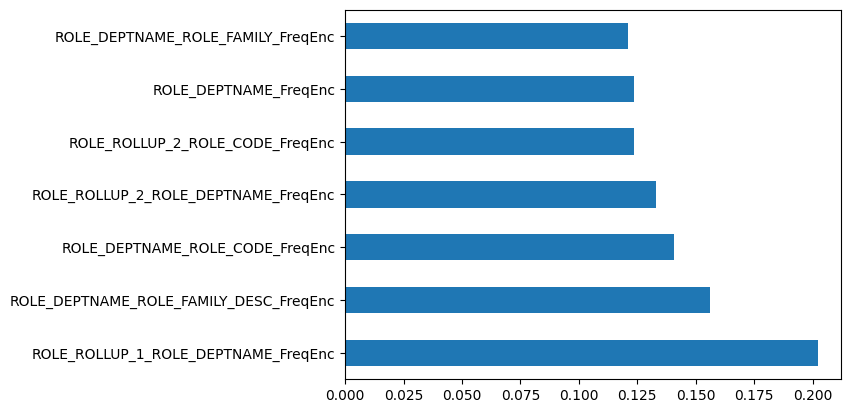

In [4]:
feat_importances = pd.Series(model_obj.model.feature_importances_, index = model_obj.model.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')

In [5]:
#train.drop(['ROLE_TITLE', 'MGR_ID'], axis = 1, inplace = True)
Y_predictions_by_class = model_obj.predict(train).astype(float) #Return 2d numpy array which is the probaility for each class label
Y = train['ACTION'].astype(float)

In [6]:
Y_predictions_by_class

array([[0.0830934 , 0.9169066 ],
       [0.03457385, 0.96542615],
       [0.09668934, 0.90331066],
       ...,
       [0.04697609, 0.95302391],
       [0.12375289, 0.87624711],
       [0.07106459, 0.92893541]])

In [8]:

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y, Y_predictions_by_class[:,1])
roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds
roc_auc_curve_df.sort_values(by = 'true_positive_rates', ascending = False, inplace = True)

In [9]:
from sklearn.metrics import roc_auc_score
auc_curve = roc_auc_score(Y, Y_predictions_by_class[:,1])
auc_curve

0.765507556653007

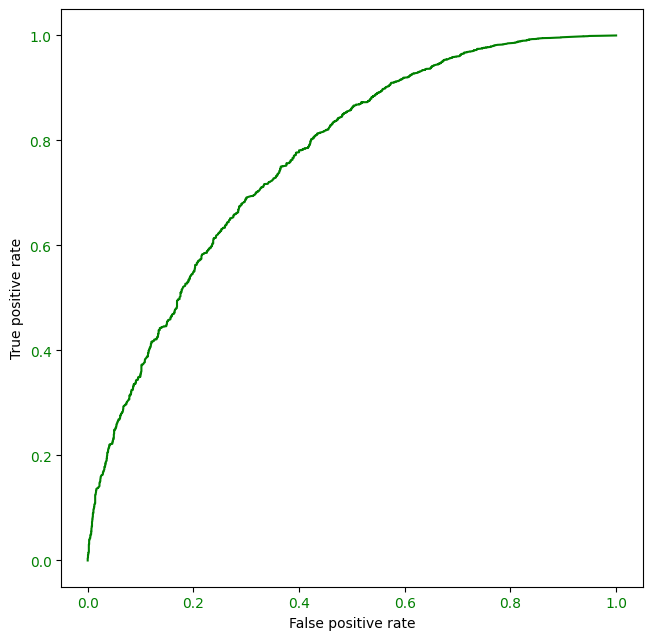

In [10]:
fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
label_str = str.format('ROC-AUC: {0}',  round(auc_curve, 3))
#ax.text(0.5, 0, label_str, fontsize = 6)

In [18]:
#roc_auc_curve_df[4000:]
roc_auc_curve_df[roc_auc_curve_df.thresholds>=0.92]

,false_positive_rates,true_positive_rates,thresholds
3470,0.421196,0.794683,0.920003
3469,0.421196,0.794613,0.920079
3468,0.421196,0.794158,0.920099
3467,0.420652,0.793983,0.920109
3466,0.420652,0.793913,0.920117
...,...,...,...
4,0.000000,0.000595,0.969659
3,0.000000,0.000455,0.969783
2,0.000000,0.000350,0.969866
1,0.000000,0.000210,0.974337


In [27]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.929189, G-Mean=0.696


In [25]:
#Y_pred = Y_predictions_by_class.argmax(-1)  
#1.0 if Y_predictions_by_class[:,1] > 0.9 else 0.0
threshold = 0.92
Y = np.array(Y).astype(int)
Y_pred = (Y_predictions_by_class[:,1] > threshold).astype(int)
Y_pred

array([0, 1, 0, ..., 1, 0, 1])

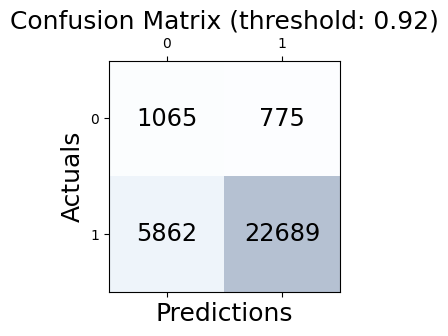

In [26]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y, Y_pred)

#print(conf_matrix)

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):

    for j in range(conf_matrix.shape[1]):

        ax.text(x = j, y = i,s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')


plt.ylabel('Actuals', fontsize=18)
plt.xlabel('Predictions', fontsize=18)
plt.title(f'Confusion Matrix (threshold: {threshold})', fontsize = 18)
plt.show()